# Activation Maps
First testing activation maps based on [this notebook](https://github.com/alexanderbeat/riverdelta-satellite-image-classification/blob/master/ALEX_BEAT_v2_1mod5project_notebook.ipynb) - see Visualize Feature Maps section.

In [1]:

# NB! Only run this once
%cd ..
%load_ext autoreload
%autoreload 2

/opt/emily/projects/measuring-quality-of-life-gauteng


In [2]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

from utils.r2_score import r_squared

2024-08-18 11:27:25.230006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 11:27:26.856153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-18 11:27:26.856264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-08-18 11:27:26.856278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-08-18 11:27:29.109486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 11:27:29.786523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10777 MB memory:  -> device: 0, name: Tesla K40c, pci bus id: 0000:05:00.0, compute capability: 3.5


In [4]:
model = load_model("outputs/model/final.h5", custom_objects={"r_squared": r_squared})

In [5]:
model.summary()

Model: "ResNet50V2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [6]:
from dvc.api import params_show

# See `model.summary()` for list of layer names, if you want to change this.
layer_names = ['conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
samples = 5
label = params_show()["train"]["label"]

In [7]:
# TODO: Load images https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility
# Create img tensor from a few randomly selected images?
# For a few img tensors, get activations and plot

from utils.load_processed_data import load_dataset
import random


def load_records(dataset='test') -> pd.DataFrame:
    test_data = load_dataset(dataset)
    selected_ids = random.choices(test_data.index.to_list(), k=samples)
    return test_data.loc[selected_ids]


In [8]:
def get_activation_model(entire_model, layer_name):
    layer = entire_model.get_layer(name=layer_name)
    return keras.Model(inputs=entire_model.input, outputs=layer.output)

In [9]:
def get_test_image(tile_path):
    tile_path = f'outputs/tiles/{tile_path}'
    img = tf.keras.utils.load_img(tile_path, target_size=(256, 256))

    # view as a tensor image
    img_tensor = tf.keras.utils.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    # Follow the Original Model Preprocessing
    # TODO replace with create_generator function
    img_tensor /= 255.

    return img_tensor

In [10]:
def plot_activations_given_img(entire_model, img_tensor, row, axes):
    for index, layer in enumerate(layer_names):
        activation_model = get_activation_model(entire_model, layer)
        
        # Returns an array for each activation layer
        activation = activation_model.predict(img_tensor, verbose=0)
        subplot = axes[row, index + 1]
        subplot.axis("off")
        subplot.matshow(activation[0, :, :, 3], cmap='viridis')
        
        if row == 0:
            subplot.set_title(layer, size=10)
        

In [11]:
def plot_actual_predicted_values(actual_value, entire_model, img_tensor, row, axes):
    actual_subplot = axes[row, len(layer_names) + 1]
    actual_subplot.axis("off")
    actual_value = round(actual_value, 3)
    actual_subplot.text(0.5, 0.5, actual_value, ha='center', va='center')
    
    prediction = entire_model.predict(img_tensor, verbose=0)
    predicted_value = round(prediction[0][0], 3)
    predicted_subplot = axes[row, len(layer_names) + 2]
    predicted_subplot.axis("off")
    predicted_subplot.text(0.5, 0.5, predicted_value, ha='center', va='center')
    
    if row == 0:
        actual_subplot.set_title(f'{label}', size=10)
        predicted_subplot.set_title('Predicted', size=10)
        

In [12]:
from utils.keras_data_format import create_generator

def plot_for_dataset(dataset):
    # Adding 3 columns for original image, actual label, and predicted
    figure, axes = plt.subplots(samples, len(layer_names) + 3, figsize=(16, 16))
    plt.setp(axes, xticks=[], yticks=[])
    records = load_records(dataset).reset_index()

    img_generator = create_generator(records, label=label, batch_size=1)
    for row in range(samples):
        sample = next(img_generator)
        img_tensor = sample[0]
        subplot = axes[row, 0]
        subplot.imshow(img_tensor[0])
        subplot.set_ylabel(records['tile'][row], size=6)

        plot_activations_given_img(model, img_tensor, row, axes)
        actual_value = records[label][row]
        plot_actual_predicted_values(actual_value, model, img_tensor, row, axes)
    plt.show()


Found 5 validated image filenames.


2024-08-18 11:27:49.889031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-08-18 11:27:50.883060: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


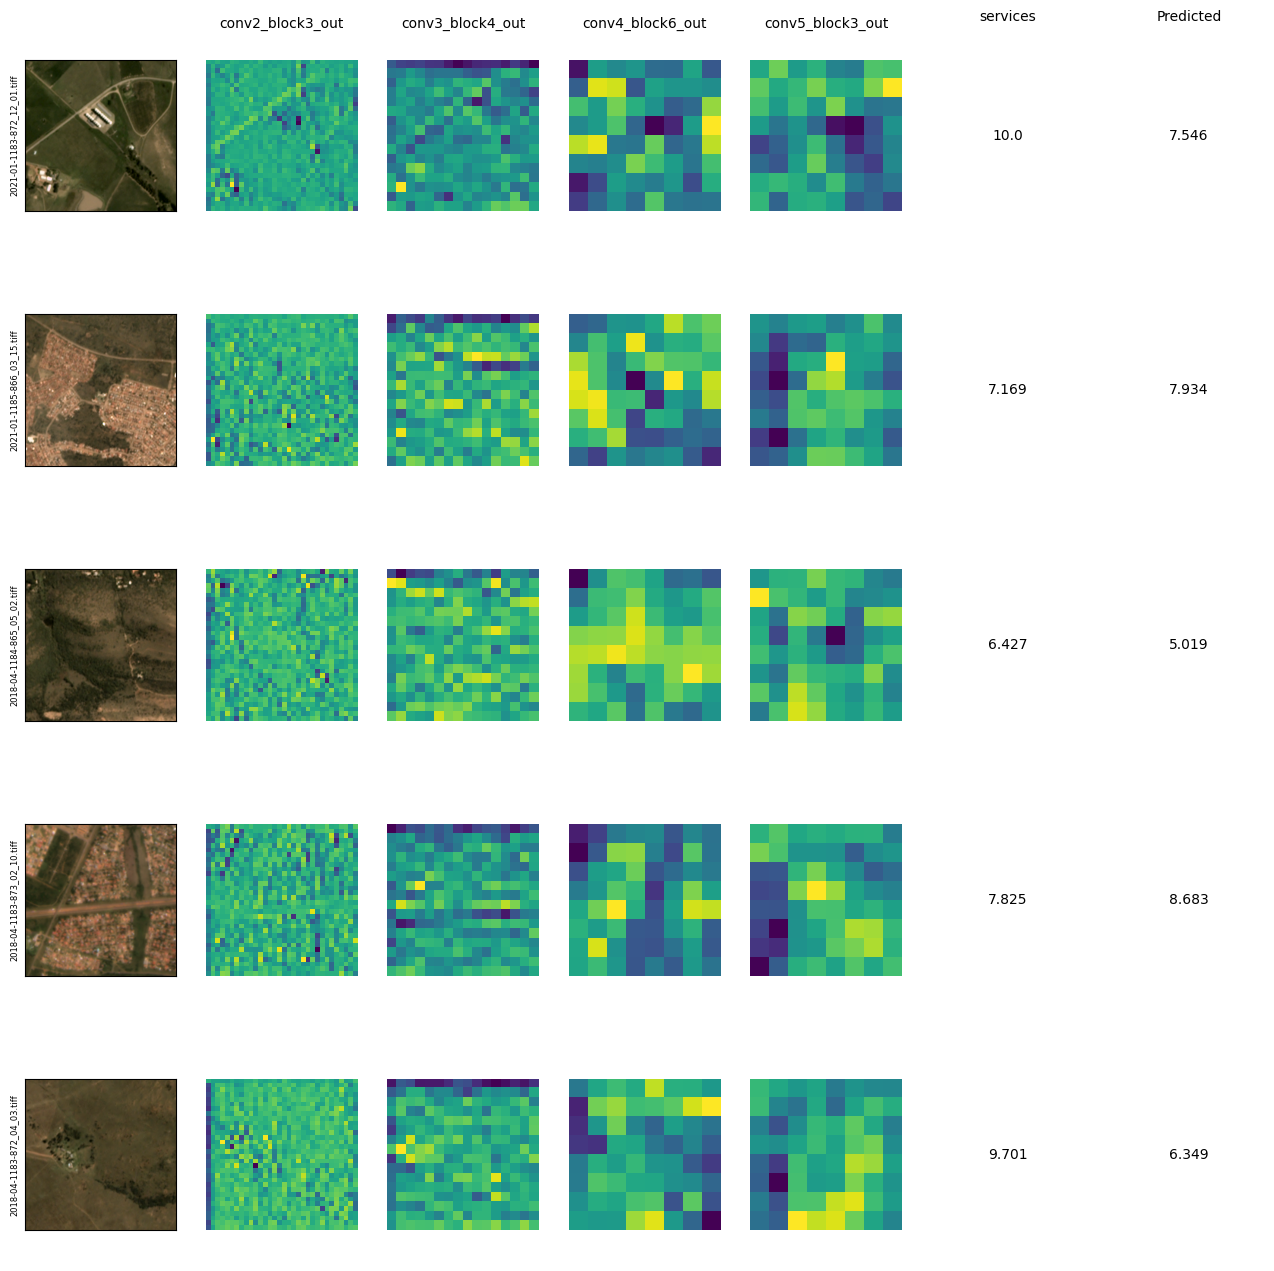

In [13]:
# Test dataset
plot_for_dataset('test')

Found 5 validated image filenames.


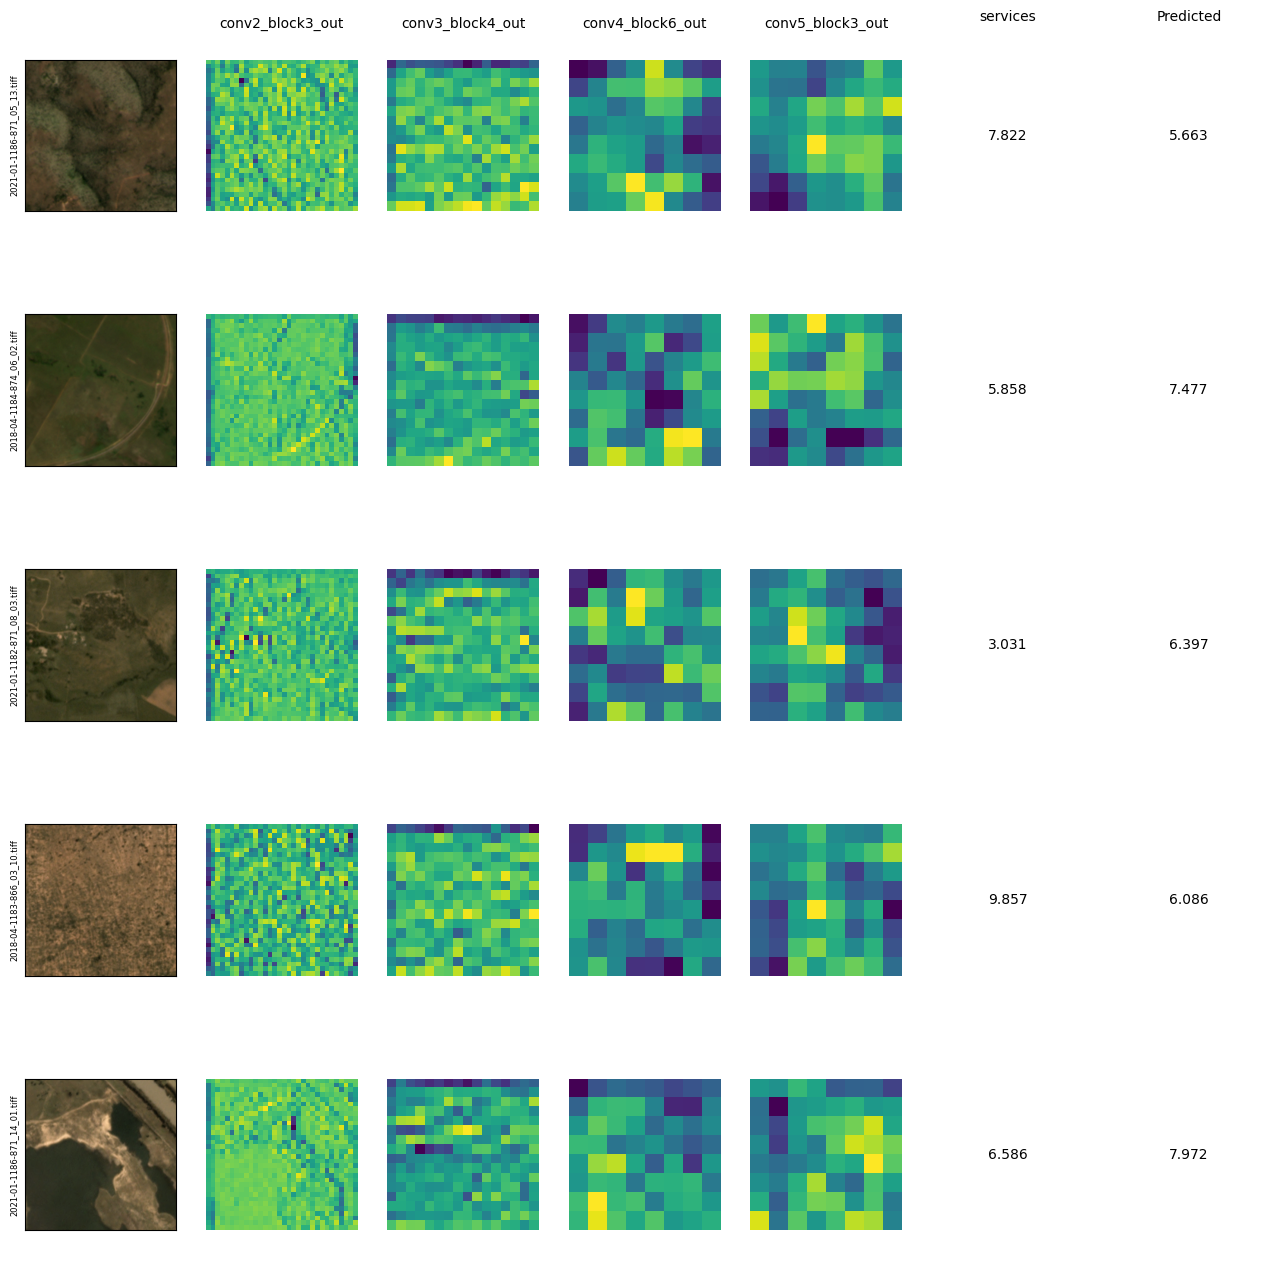

In [14]:
# Train dataset
plot_for_dataset('train')